In [1]:
import numpy as np
import pylab as pp
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
import os

pp.style.use("bmh")

# Technical Analysis library
import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
fileName = "ASIA_D_SH - Copy.csv"
loc = "D:\Stocks"

os.chdir(loc)
# Loading in the Data
df = pd.read_csv(fileName, delimiter=",")

In [3]:
## Datetime conversion
df['<DTYYYYMMDD>'] = pd.to_datetime(df['<DTYYYYMMDD>'], format='%Y%m%d')

# Setting the index
df.set_index('<DTYYYYMMDD>', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

In [4]:
## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="<Open>", high="<High>", low="<Low>", close="<Close>", volume="<Vol>", fillna=True)

c:\users\light\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\light\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [5]:
# Dropping everything else besides 'Close' and the Indicators
df.drop(['<Ticker>', '<Per>', '<TIME>', '<Open>', '<High>', '<Low>', '<Vol>', '<Openint>', 'a', 'b'], axis=1, inplace=True)

df.rename(columns={"<Close>": "Close", "<DTYYYYMMDD>": "Date"}, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1500)

In [6]:
## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [7]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    pp.figure(figsize=(16,5))
    pp.plot(history['val_loss'])
    pp.plot(history['loss'])
    pp.legend(['val_loss', 'loss'])
    pp.title('Loss')
    pp.xlabel('Epochs')
    pp.ylabel('Loss')
    pp.show()
    
    pp.figure(figsize=(16,5))
    pp.plot(history['val_accuracy'])
    pp.plot(history['accuracy'])
    pp.legend(['val_accuracy', 'accuracy'])
    pp.title('Accuracy')
    pp.xlabel('Epochs')
    pp.ylabel('Accuracy')
    pp.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          

def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

# Days of prediction:

In [8]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

# Modding the network:

In [28]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=50, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=200, batch_size=128, validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 90)           59040     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           28200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 60)                26640     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
Total params: 115,710
Trainable params: 115,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 [==============================] - 6s 604ms/step - loss: 1.2457 - accuracy: 0.0268 - val_loss: 200.2998 - val_accuracy: 0.0435
Epoch 2/200
10/10 [==============================] - 5s 466ms/step - loss: 0.8717 - accuracy: 0.0235 

10/10 [==============================] - 4s 438ms/step - loss: 0.0151 - accuracy: 0.1768 - val_loss: 78.1656 - val_accuracy: 0.0870
Epoch 52/200
10/10 [==============================] - 4s 448ms/step - loss: 0.0148 - accuracy: 0.1800 - val_loss: 77.9931 - val_accuracy: 0.0870
Epoch 53/200
10/10 [==============================] - 4s 439ms/step - loss: 0.0146 - accuracy: 0.1760 - val_loss: 77.8438 - val_accuracy: 0.0870
Epoch 54/200
10/10 [==============================] - 4s 433ms/step - loss: 0.0144 - accuracy: 0.1776 - val_loss: 77.7298 - val_accuracy: 0.0870
Epoch 55/200
10/10 [==============================] - 5s 461ms/step - loss: 0.0143 - accuracy: 0.1825 - val_loss: 77.5534 - val_accuracy: 0.0870
Epoch 56/200
10/10 [==============================] - 5s 466ms/step - loss: 0.0141 - accuracy: 0.1792 - val_loss: 77.4658 - val_accuracy: 0.0870
Epoch 57/200
10/10 [==============================] - 4s 432ms/step - loss: 0.0140 - accuracy: 0.1849 - val_loss: 77.3377 - val_accuracy: 0.087

10/10 [==============================] - 4s 433ms/step - loss: 0.0089 - accuracy: 0.2506 - val_loss: 75.6759 - val_accuracy: 0.0435
Epoch 108/200
10/10 [==============================] - 4s 435ms/step - loss: 0.0089 - accuracy: 0.2498 - val_loss: 75.8894 - val_accuracy: 0.0435
Epoch 109/200
10/10 [==============================] - 4s 447ms/step - loss: 0.0088 - accuracy: 0.2506 - val_loss: 76.1096 - val_accuracy: 0.0435
Epoch 110/200
10/10 [==============================] - 4s 435ms/step - loss: 0.0090 - accuracy: 0.2587 - val_loss: 76.2461 - val_accuracy: 0.0435
Epoch 111/200
10/10 [==============================] - 4s 435ms/step - loss: 0.0102 - accuracy: 0.2514 - val_loss: 76.2656 - val_accuracy: 0.0435
Epoch 112/200
10/10 [==============================] - 4s 434ms/step - loss: 0.0104 - accuracy: 0.2498 - val_loss: 76.0750 - val_accuracy: 0.0435
Epoch 113/200
10/10 [==============================] - 4s 435ms/step - loss: 0.0134 - accuracy: 0.2603 - val_loss: 77.6131 - val_accuracy:

10/10 [==============================] - 4s 445ms/step - loss: 0.0064 - accuracy: 0.2895 - val_loss: 77.4697 - val_accuracy: 0.0362
Epoch 164/200
10/10 [==============================] - 4s 435ms/step - loss: 0.0064 - accuracy: 0.2814 - val_loss: 77.5871 - val_accuracy: 0.0362
Epoch 165/200
10/10 [==============================] - 4s 436ms/step - loss: 0.0063 - accuracy: 0.2879 - val_loss: 77.5672 - val_accuracy: 0.0362
Epoch 166/200
10/10 [==============================] - 4s 435ms/step - loss: 0.0063 - accuracy: 0.2766 - val_loss: 77.5107 - val_accuracy: 0.0435
Epoch 167/200
10/10 [==============================] - 4s 434ms/step - loss: 0.0062 - accuracy: 0.2847 - val_loss: 77.5067 - val_accuracy: 0.0435
Epoch 168/200
10/10 [==============================] - 4s 441ms/step - loss: 0.0062 - accuracy: 0.2912 - val_loss: 77.6436 - val_accuracy: 0.0435
Epoch 169/200
10/10 [==============================] - 4s 439ms/step - loss: 0.0063 - accuracy: 0.2839 - val_loss: 77.6303 - val_accuracy:

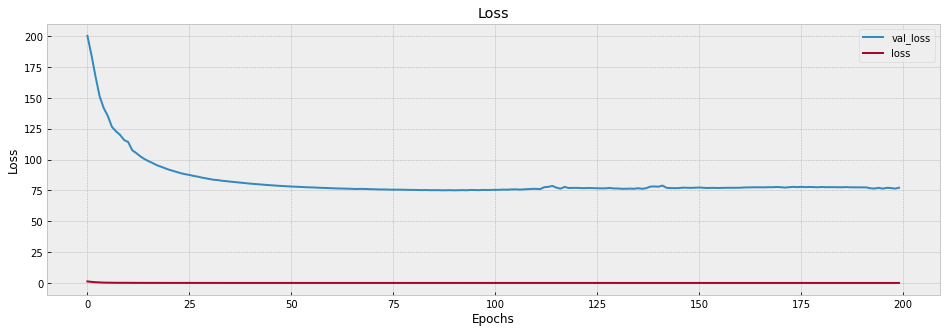

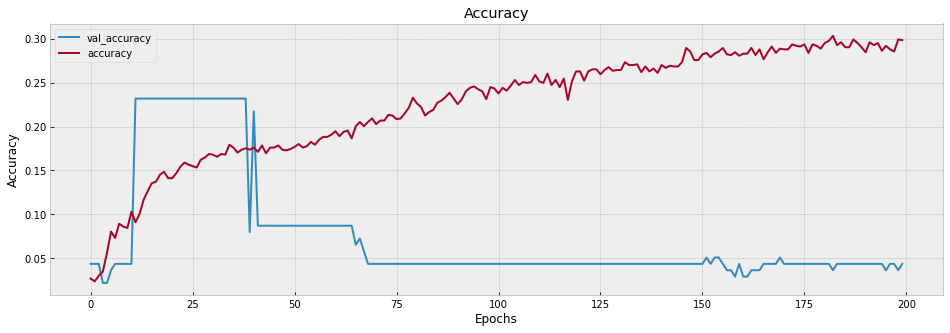

In [29]:
visualize_training_results(res)

RMSE: 587.4953174059743


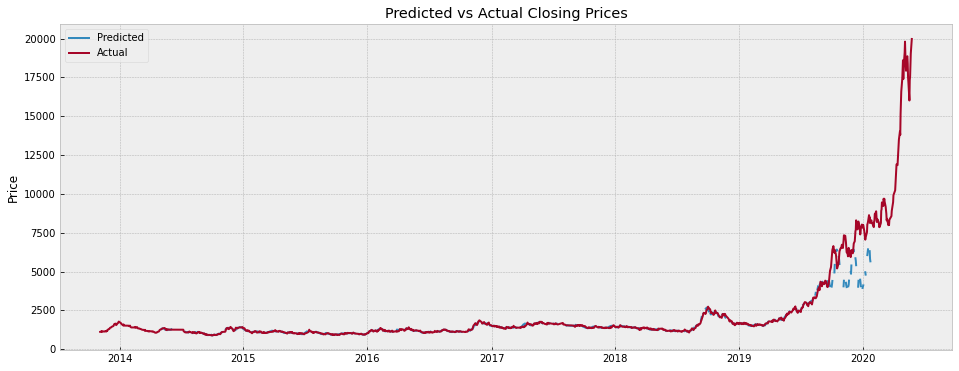

In [30]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
pp.figure(figsize=(16,6))

# Plotting those predictions
pp.plot(predictions, label='Predicted')

# Plotting the actual values
pp.plot(actual, label='Actual')

pp.title(f"Predicted vs Actual Closing Prices")
pp.ylabel("Price")
pp . legend ()
# pp . xlim ( '2015-05-01' , '2020-05-01' )
pp.show()

                  Close
2020-05-25  4037.141602
2020-05-26  4419.875000
2020-05-27  4144.038086
2020-05-28  4141.793945
2020-05-29  4467.413574
2020-06-01  4275.016113
2020-06-02  4079.013184
2020-06-03  3970.238281
2020-06-04  4183.469238
2020-06-05  3941.726318
2020-06-08  4045.078125
2020-06-09  4131.540039
2020-06-10  4403.567383
2020-06-11  4384.712891
2020-06-12  4689.707031
2020-06-15  4965.892578
2020-06-16  4843.812988
2020-06-17  5389.931152
2020-06-18  5655.073242
2020-06-19  6072.718750
2020-06-22  6277.929199
2020-06-23  6442.253906
2020-06-24  6295.768066
2020-06-25  6322.183594
2020-06-26  6333.503418
2020-06-29  5820.988281
2020-06-30  5685.297852
2020-07-01  5393.449219
2020-07-02  5466.540039
2020-07-03  5372.300781


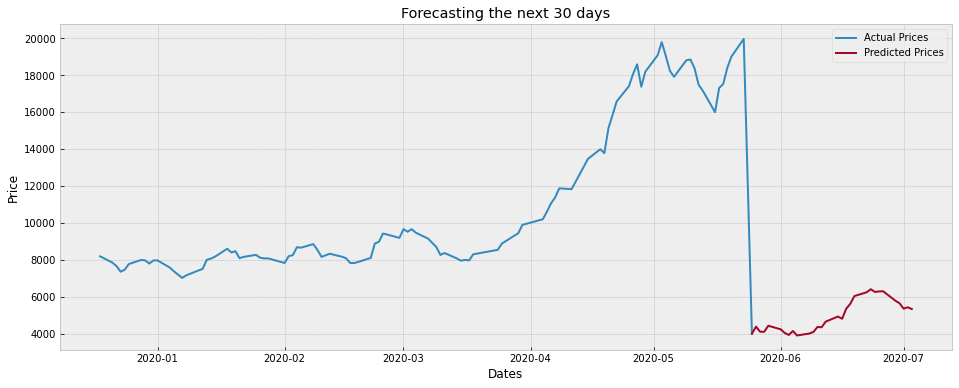

In [31]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
pp.figure(figsize=(16,6))
pp.plot(actual, label="Actual Prices")
pp.plot(preds, label="Predicted Prices")
pp.ylabel("Price")
pp.xlabel("Dates")
pp.title(f"Forecasting the next {len(yhat)} days")
pp . legend ()
pp.show()